In [230]:
import pickle
import pandas as pd
import random 
import numpy as np
from datetime import datetime, timedelta, time, date

with open('average_tap_dict.pkl', 'rb') as f:
    average_attention_times_dict = pickle.load(f)
with open('average_tep_dict.pkl', 'rb') as f:
    average_waiting_times_dict = pickle.load(f)
with open('processing_rate_dict.pkl', 'rb') as f:
    processing_rate_dict = pickle.load(f)
with open('consultorios.pkl', 'rb') as f:
    consultorios = pickle.load(f)
with open('counts_by_time_slot.pkl', 'rb') as f:
    counts_by_time_slot = pickle.load(f)
    
import json
with open('arrival_dist.json', 'r') as f:
    arrival_distributions = json.load(f)
    
df_test = pd.read_csv('DataTiempos_prueba.csv')

In [231]:
df_test

,Sucursal,EstudioModalidad,ReservacionSP,TEPFechaEspera,TEPHoraInicio,TEPHoraFin,TEPMinutos,TAPFechaAtencion,TAPHoraInicio,TAPHoraFin,TAPMinutos,TotalMinutos,FechaEvento
0,CULIACAN,TOMOGRAFIA,1008058126,20250325,2025-03-26 17:00:00,2025-03-25T16:52:33.0300000,0.00,20250325,2025-03-25T16:52:33.0300000,2025-03-25T17:02:20.8070000,9.78,9.78,2025-03-25
1,CULIACAN,TOMOGRAFIA,1008058073,20250325,2025-03-25 16:40:00,2025-03-25T16:46:03.0030000,6.05,20250325,2025-03-25T16:46:03.0030000,2025-03-25T16:50:57.9530000,4.90,10.95,2025-03-25
2,CULIACAN,TOMOGRAFIA,1008056893,20250325,2025-03-25 18:10:00,2025-03-25T16:34:30.6830000,0.00,20250325,2025-03-25T16:34:30.6830000,2025-03-25T16:40:45.6100000,6.25,6.25,2025-03-25
3,CULIACAN,TOMOGRAFIA,1008055733,20250325,2025-03-25 16:00:00,2025-03-25T16:09:56.6530000,9.93,20250325,2025-03-25T16:09:56.6530000,2025-03-25T16:14:32.4370000,4.60,14.53,2025-03-25
4,CULIACAN UNIVERSITARIOS,OPTOMETRIA,35388355,20250325,2025-03-25 15:57:54.84,2025-03-25T15:58:24.0000000,0.50,20250325,2025-03-25T15:58:24.0000000,2025-03-25T16:02:26.7000000,4.03,4.53,2025-03-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20327,CULIACAN UNIVERSITARIOS,DENSITOMETRIA,1011594732,20250331,2025-03-31 10:40:00,2025-03-31T09:58:39.3530000,0.00,20250331,2025-03-31T09:58:39.3530000,2025-03-31T10:09:09.1200000,10.50,10.50,2025-03-31
20328,CULIACAN UNIVERSITARIOS,DENSITOMETRIA,1011550210,20250331,2025-03-31 10:30:00,2025-03-31T09:09:43.8700000,0.00,20250331,2025-03-31T09:09:43.8700000,2025-03-31T09:16:43.8930000,7.00,7.00,2025-03-31
20329,CULIACAN UNIVERSITARIOS,DENSITOMETRIA,1011485950,20250331,2025-03-31 09:50:00,2025-03-31T08:27:18.0370000,0.00,20250331,2025-03-31T08:27:18.0370000,2025-03-31T08:34:16.1670000,6.97,6.97,2025-03-31
20330,CULIACAN,RESONANCIA MAGNETICA,1011651945,20250331,2025-03-31 14:20:00,2025-03-31T14:18:46.9000000,0.00,20250331,2025-03-31T14:18:46.9000000,2025-03-31T14:54:51.6330000,36.08,36.08,2025-03-31


In [232]:
arrival_distributions

{'COYOACAN': ['lognorm', [1.2215397493446571, 0, 159.8405507423476]],
 'CULIACAN': ['gamma', [1.619495155616731, 0, 69.73310913636284]],
 'CULIACAN CAÑADAS': ['lognorm', [0.8652386361084784, 0, 56.198771730346856]],
 'CULIACAN COLEGIO MILITAR': ['lognorm',
  [1.119100236765752, 0, 40.92054951604537]],
 'CULIACAN LA CONQUISTA': ['lognorm',
  [1.2428355570733471, 0, 18.670752377463256]],
 'CULIACAN LAS TORRES': ['lognorm',
  [0.9317858441652889, 0, 28.12160263681599]],
 'CULIACAN NAKAYAMA': ['lognorm', [1.2036100393950178, 0, 18.17961711884912]],
 'CULIACAN UNIVERSITARIOS': ['lognorm',
  [0.9373100383273191, 0, 49.686044664249536]]}

# Funciones auxiliares

In [233]:
from scipy import stats

dist_map = {
    'lognorm': stats.lognorm,
    'gamma': stats.gamma,
    'expon': stats.expon,
    'norm': stats.norm
}

def simulate_patient_arrivals_from_distribution(
    num_patients,
    start_time_dt, # Ya debe ser un objeto datetime.datetime
    end_time_dt,   # Ya debe ser un objeto datetime.datetime
    sucursal,
):
    """
    Simula las horas de llegada de los pacientes siguiendo una distribución específica
    para la sucursal dada. Los tiempos generados son offsets en minutos desde start_time_dt.
    """
    arrival_times = []
    dist_name_str, params = arrival_distributions[sucursal]
    dist_constructor = dist_map.get(dist_name_str)
    oversample_factor = 2.0 
    samples_to_generate = int(num_patients * oversample_factor)
    if samples_to_generate < num_patients + 5 : samples_to_generate = num_patients + 5 # Mínimo para tener margen
    generated_time_offsets_minutes = []

    if dist_name_str == 'lognorm' and len(params) == 3:
        generated_time_offsets_minutes = dist_constructor.rvs(s=params[0], loc=params[1], scale=params[2], size=samples_to_generate)
    elif dist_name_str == 'gamma' and len(params) == 3:
        generated_time_offsets_minutes = dist_constructor.rvs(a=params[0], loc=params[1], scale=params[2], size=samples_to_generate)
    elif dist_name_str == 'expon' and len(params) == 2: # loc, scale
        generated_time_offsets_minutes = dist_constructor.rvs(loc=params[0], scale=params[1], size=samples_to_generate)
    elif dist_name_str == 'norm' and len(params) == 2: # loc (mean), scale (std)
         generated_time_offsets_minutes = dist_constructor.rvs(loc=params[0], scale=params[1], size=samples_to_generate)
    simulation_day_date = start_time_dt.date()

    for offset_minutes in generated_time_offsets_minutes:
        current_offset_minutes = max(0, float(offset_minutes))
        arrival_time = start_time_dt + timedelta(minutes=current_offset_minutes)
        if arrival_time.date() == simulation_day_date and arrival_time <= end_time_dt and arrival_time >= start_time_dt:
            arrival_times.append(arrival_time)
    arrival_times.sort()
    final_arrival_times = arrival_times[:num_patients]

    if len(final_arrival_times) < num_patients:
        print(f"Advertencia: Solo se pudieron generar {len(final_arrival_times)} de {num_patients} llegadas "
              f"para la sucursal '{sucursal}' dentro del horario operativo usando la distribución {dist_name_str}. "
              "Esto puede ocurrir si la distribución está muy dispersa o centrada fuera del horario.")
    return final_arrival_times

In [234]:
def filter_studies_by_sucursal(df, sucursal):
    studies_in_sucursal = df[df['Sucursal'] == sucursal]['EstudioModalidad'].unique().tolist()
    return studies_in_sucursal

def get_study_frequencies(df, sucursal):
    sucursal_df = df[df['Sucursal'] == sucursal]
    study_counts = sucursal_df['EstudioModalidad'].value_counts()
    return study_counts.to_dict()

def simulate_patient_arrivals(num_patients, start_time, end_time):
    arrival_times = []
    time_range_minutes = (end_time - start_time).total_seconds() / 60
    if time_range_minutes <=0: time_range_minutes = 1 # Evitar error si el rango es 0
    for _ in range(num_patients):
        random_minutes = random.uniform(0, time_range_minutes)
        arrival_time = start_time + timedelta(minutes=random_minutes)
        arrival_times.append(arrival_time)
    arrival_times.sort()
    return arrival_times

def get_time_slot_key_from_datetime(dt_obj):
    if pd.isna(dt_obj):
        return None
    interval_start_minute = (dt_obj.minute // 30) * 30
    interval_start = dt_obj.replace(minute=interval_start_minute, second=0, microsecond=0)
    interval_end = interval_start + timedelta(minutes=30)
    return f"{interval_start.strftime('%I:%M%p')} - {interval_end.strftime('%I:%M%p')}"

def simulate_patient_studies_requests(
    arrival_time, 
    sucursal,    
    studies_list,  
    total_counts_by_interval_dict,
    overall_study_frequencies,    
    max_studies_per_patient
):
    if not studies_list: 
        return []
    num_studies_for_patient = random.randint(1, min(max_studies_per_patient, len(studies_list)))
    time_slot_key_str = get_time_slot_key_from_datetime(arrival_time)
    slot_specific_frequencies = {}
    if time_slot_key_str:
        for study in studies_list:
            count = total_counts_by_interval_dict.get((sucursal, study, time_slot_key_str), 0)
            if count > 0:
                slot_specific_frequencies[study] = count
    
    frequencies_to_use = slot_specific_frequencies
    source_of_frequencies = "intervalo específico"
    # Fallback a frecuencias generales si no hay datos para el intervalo
    if not frequencies_to_use:
        frequencies_to_use = {s: f for s, f in overall_study_frequencies.items() if s in studies_list}
        source_of_frequencies = "frecuencias generales (fallback)"
        if not frequencies_to_use: 
            return random.sample(studies_list, k=num_studies_for_patient) if len(studies_list) >= num_studies_for_patient else list(studies_list)

    total_frequency = sum(frequencies_to_use.values())
    study_probabilities = {study: freq / total_frequency for study, freq in frequencies_to_use.items()}

    possible_choices = list(study_probabilities.keys())
    num_studies_to_choose = min(num_studies_for_patient, len(possible_choices))

    chosen_studies = random.choices(
        possible_choices,
        weights=[study_probabilities[s] for s in possible_choices],
        k=num_studies_to_choose
    )
    return list(set(chosen_studies)) 

def generate_simulation_data(
    df_for_frequencies, 
    sucursal, 
    num_patients, 
    start_hour, 
    end_hour, 
    max_studies_per_patient,
    counts_by_interval_dict 
):
    available_studies = filter_studies_by_sucursal(df_for_frequencies, sucursal)
    if not available_studies:
        print(f"No hay estudios disponibles para la sucursal: {sucursal}")
        return []
    
    overall_study_frequencies_for_sucursal = get_study_frequencies(df_for_frequencies, sucursal)
    
    today = datetime.now().date()
    start_time_sim = datetime.combine(today, time(start_hour, 0))
    end_time_sim = datetime.combine(today, time(end_hour, 0))
    
    arrival_times = simulate_patient_arrivals_from_distribution(num_patients, start_time_sim, end_time_sim, sucursal)
    
    patient_data_list = []
    for i, arrival in enumerate(arrival_times):
        requested = simulate_patient_studies_requests(
            arrival, 
            sucursal,
            available_studies,
            counts_by_interval_dict,
            overall_study_frequencies_for_sucursal,
            max_studies_per_patient
        )
        
        if requested:
            patient_data_list.append({
                'Patient_ID': f"GenP{i+1}", 
                'Arrival_Time': arrival,
                'Requested_Studies': requested,
                'Remaining_Studies': list(requested),
                'Current_Availability_Time': arrival,
                'Path_Details': [],
                'Total_Wait_Time_Clinic': timedelta(0),
                'Overall_Completion_Time': None,
                'Needs_New_Step_Decision': True
            })
    return patient_data_list

In [235]:
def get_tep_historical_estimate(sucursal, study, current_time, average_waiting_times_dict, default_tep):
    minutes_past_hour = current_time.minute
    minutes_to_subtract = minutes_past_hour % 30
    interval_start_dt = current_time - timedelta(minutes=minutes_to_subtract)
    interval_start_dt = interval_start_dt.replace(second=0, microsecond=0)
    interval_end_dt = interval_start_dt + pd.Timedelta(minutes=30)
    tep_interval_key_str = f"{interval_start_dt.strftime('%I:%M%p')} - {interval_end_dt.strftime('%I:%M%p')}"
    
    tep_key = (sucursal, study, tep_interval_key_str)
    return average_waiting_times_dict.get(tep_key, default_tep)


def estimate_current_study_queues_wait_times(
    sucursal,
    studies_patient_needs, 
    room_occupancy,
    global_patient_queue, 
    current_decision_time, # Cuándo está disponible el paciente para el que se calcula
    processing_rate_dict, # (TAP_promedio / NumConsultoriosReales)
):
    study_wait_estimates = {}
    line_lengths = {}

    for study_type_needed_by_patient in studies_patient_needs:
        room_for_this_study = study_type_needed_by_patient
        room_specific_free_at = room_occupancy.get(room_for_this_study, datetime.min)
    
        if isinstance(current_decision_time, str):
            time_obj = datetime.strptime(current_decision_time, '%H:%M:%S').time()
            today_date = date.today()
            current_decision_time = datetime.combine(today_date, time_obj)

        base_wait_for_specific_room = max(0, (room_specific_free_at - current_decision_time).total_seconds() / 60)

        count_others_wanting_this_study_type = 0
        potential_room_availability_for_queue = current_decision_time + timedelta(minutes=base_wait_for_specific_room)
        for other_patient_in_queue in global_patient_queue:
            if study_type_needed_by_patient in other_patient_in_queue['Remaining_Studies'] and \
               other_patient_in_queue['Current_Availability_Time'] <= potential_room_availability_for_queue:
                count_others_wanting_this_study_type += 1
                
        processing_rate_for_study = processing_rate_dict.get(
            (sucursal, study_type_needed_by_patient),
            DEFAULT_PROCESSING_TIME 
        )
        estimated_queue_clearance_for_study_type = count_others_wanting_this_study_type * processing_rate_for_study
        total_estimated_wait_for_this_study = base_wait_for_specific_room + estimated_queue_clearance_for_study_type
        study_wait_estimates[study_type_needed_by_patient] = total_estimated_wait_for_this_study
        line_lengths[study_type_needed_by_patient] = count_others_wanting_this_study_type
    return study_wait_estimates, line_lengths

def infer_room_capabilities_from_studies(df, sucursal):
    sucursal_studies = df[df['Sucursal'] == sucursal]['EstudioModalidad'].unique()
    # Cada estudio tiene su propia "sala" dedicada con el mismo nombre
    room_capabilities = {study: [study] for study in sucursal_studies}
    return room_capabilities

# Simulation script

In [236]:
def run_multi_room_simulation_flexible(
    path_selection_algorithm_func, 
    algorithm_name, 
    *kwargs,
    ):
    print(f"\n--- Ejecutando Simulación Multi-Sala Flexible: {algorithm_name} ---")
    preprocessed_paths = {} 
    patients_list_orig = kwargs[0].get('patients_list_orig')
    all_studies_in_sucursal = kwargs[0].get('all_studies_in_sucursal')
    room_capabilities = kwargs[0].get('room_capabilities')

    patients_list_sim = [p.copy() for p in patients_list_orig]
    for p in patients_list_sim:
        p['Requested_Studies'] = list(p['Requested_Studies'])
        p['Remaining_Studies'] = list(p['Requested_Studies']) 
        p['Assigned_Path_Or_Step'] = None 
        p['Path_Details'] = []
        p['Total_Wait_Time_Clinic'] = timedelta(0)
        p['Current_Availability_Time'] = p['Arrival_Time']
        p['Needs_New_Path_Decision'] = True

    room_occupancy = {room_name: datetime.min for room_name in room_capabilities.keys()}
    
    event_queue = [] 
    processed_patients_final_details = []
    # Mapa para acceder a los objetos paciente por ID
    active_patients_map = {p['Patient_ID']: p for p in patients_list_sim} 
    patient_arrival_idx = 0 # Para rastrear la lista original de pacientes_list_sim
    patients_list_sim.sort(key=lambda p: p['Arrival_Time'])

    current_time = datetime.min
    if patients_list_sim:
        current_time = patients_list_sim[0]['Arrival_Time']

    max_loops = sum(len(p['Requested_Studies']) for p in patients_list_sim) * (len(patients_list_sim) + 5) + 200
    loop_count = 0
    clinic_waiting_line = [] # Pacientes que han llegado y esperan su turno o una sala

    while (patient_arrival_idx < len(patients_list_sim) or event_queue or clinic_waiting_line) and loop_count < max_loops:
        loop_count += 1
        patient_processed_this_cycle_flag = False
        newly_arrived_this_cycle = False
        
        while patient_arrival_idx < len(patients_list_sim) and patients_list_sim[patient_arrival_idx]['Arrival_Time'] <= current_time:
            arrived_patient_data = patients_list_sim[patient_arrival_idx]
            if arrived_patient_data['Patient_ID'] not in [p_obj['Patient_ID'] for p_obj in clinic_waiting_line] and \
               arrived_patient_data not in processed_patients_final_details: # Evitar duplicados
                 clinic_waiting_line.append(arrived_patient_data)
            patient_arrival_idx += 1
            newly_arrived_this_cycle = True
            patient_processed_this_cycle_flag = True 
            
        event_queue.sort(key=lambda e: e['time'])
        temp_event_queue_for_reprocessing = []
        processed_event_this_iteration = False

        while event_queue and event_queue[0]['time'] <= current_time:
            current_event = event_queue.pop(0)
            processed_event_this_iteration = True
            patient_obj_from_event = active_patients_map.get(current_event['patient_id'])
            if not patient_obj_from_event or patient_obj_from_event in processed_patients_final_details:
                continue
            patient_processed_this_cycle_flag = True 

            if current_event['type'] == 'STUDY_COMPLETED':
                if not patient_obj_from_event['Remaining_Studies']:
                    patient_obj_from_event['Overall_Completion_Time'] = current_time # Tiempo de finalización del estudio
                    if patient_obj_from_event not in processed_patients_final_details:
                         processed_patients_final_details.append(patient_obj_from_event)
                else:
                    patient_obj_from_event['Needs_New_Path_Decision'] = True
                    if patient_obj_from_event not in clinic_waiting_line:
                        clinic_waiting_line.append(patient_obj_from_event)
        event_queue.extend(temp_event_queue_for_reprocessing)

        clinic_waiting_line.sort(key=lambda p: (p['Current_Availability_Time'], p['Arrival_Time']))
        patient_made_progress_in_clinic_line = False
        for i in range(len(clinic_waiting_line) -1, -1, -1): # Iterar al revés para poder hacer pop
            patient_to_process = clinic_waiting_line[i]

            if patient_to_process['Current_Availability_Time'] > current_time:
                continue # Paciente aún no está listo
            if not patient_to_process['Remaining_Studies']: # Ya terminó
                if patient_to_process not in processed_patients_final_details:
                    patient_to_process['Overall_Completion_Time'] = patient_to_process['Current_Availability_Time']
                    processed_patients_final_details.append(patient_to_process)
                clinic_waiting_line.pop(i)
                patient_processed_this_cycle_flag = True
                continue
            next_study_to_attempt = None
            
            patient_id_key = patient_to_process['Patient_ID']
            if patient_id_key in preprocessed_paths and preprocessed_paths[patient_id_key]:
                next_study_to_attempt = preprocessed_paths[patient_id_key].pop(0) # Tomar y remover de la ruta preprocesada
                patient_to_process['Needs_New_Path_Decision'] = False # Sigue una ruta
                if not preprocessed_paths[patient_id_key]: # Si la ruta se vació
                    del preprocessed_paths[patient_id_key] 
            elif patient_to_process['Needs_New_Path_Decision'] or not patient_to_process.get('Assigned_Path_Or_Step'):
                decision_moment = max(current_time, patient_to_process['Current_Availability_Time'])
                others_in_clinic_line = [p for idx, p in enumerate(clinic_waiting_line) if idx != i]

                current_study_wait_estimates, line_lengths = estimate_current_study_queues_wait_times(
                    SIMULATED_SUCURSAL, patient_to_process['Remaining_Studies'], 
                    room_occupancy, others_in_clinic_line,
                    decision_moment, processing_rate_dict,
                )
                path_result, is_full_path = path_selection_algorithm_func(
                    patient_to_process, current_study_wait_estimates,
                    room_occupancy, decision_moment, line_lengths,   
                )
                patient_to_process['Needs_New_Path_Decision'] = False

                if is_full_path and path_result:
                    preprocessed_paths[patient_id_key] = list(path_result) # Almacenar ruta completa
                    if preprocessed_paths[patient_id_key]:
                         next_study_to_attempt = preprocessed_paths[patient_id_key].pop(0)
                elif not is_full_path and path_result: # Algoritmo solo dio el siguiente paso
                    next_study_to_attempt = path_result
        
            elif isinstance(patient_to_process.get('Assigned_Path_Or_Step'), str): 
                 next_study_to_attempt = patient_to_process['Assigned_Path_Or_Step']

            if next_study_to_attempt and next_study_to_attempt in patient_to_process['Remaining_Studies']:
                room_for_this_study = next_study_to_attempt 
                
                if room_occupancy.get(room_for_this_study, datetime.min) <= current_time: # La sala está libre AHORA
                    clinic_waiting_line.pop(i) # Sacar al paciente de la línea, va a ser procesado
                    patient_processed_this_cycle_flag = True
                    patient_made_progress_in_clinic_line = True

                    actual_study_start_time = current_time 
                    wait_for_this_study_instance = (actual_study_start_time - patient_to_process['Current_Availability_Time']).total_seconds() / 60
                    patient_to_process['Total_Wait_Time_Clinic'] += timedelta(minutes=max(0, wait_for_this_study_instance))
                    tap_time = average_attention_times_dict.get((SIMULATED_SUCURSAL, next_study_to_attempt), DEFAULT_TAP_TIME)
                    study_completion_time = actual_study_start_time + timedelta(minutes=tap_time)

                    patient_to_process['Path_Details'].append({
                        'Study': next_study_to_attempt, 'Room': room_for_this_study,
                        'Wait_Before_Study_Mins': round(max(0, wait_for_this_study_instance),2),
                        'Start_Time': actual_study_start_time, 'TAP_Mins': tap_time,
                        'Completion_Time': study_completion_time
                    })
                    
                    patient_to_process['Remaining_Studies'].remove(next_study_to_attempt)
                    patient_to_process['Current_Availability_Time'] = study_completion_time 
                    room_occupancy[room_for_this_study] = study_completion_time 
                    
                    if not (patient_id_key in preprocessed_paths and preprocessed_paths[patient_id_key]):
                        patient_to_process['Assigned_Path_Or_Step'] = None # Limpiar para la próxima decisión
                        patient_to_process['Needs_New_Path_Decision'] = True
                    
                    event_queue.append({'time': study_completion_time, 'type': 'STUDY_COMPLETED', 'patient_id': patient_to_process['Patient_ID']})
                    break 
                else: # La sala específica está ocupada
                    next_check_time_for_patient = max(room_occupancy.get(room_for_this_study, current_time + timedelta(minutes=1)), patient_to_process['Current_Availability_Time'])
                    already_scheduled_recheck = any(
                        ev['type'] == 'PROCESS_PATIENT_EVENT' and 
                        ev['patient_id'] == patient_to_process['Patient_ID'] and
                        ev['time'] >= current_time # Solo nos importa si ya hay uno programado para el futuro
                        for ev in event_queue
                    )
                    if not already_scheduled_recheck:
                         event_queue.append({'time': next_check_time_for_patient, 'type': 'PROCESS_PATIENT_EVENT', 'patient_id': patient_to_process['Patient_ID']})

            elif not next_study_to_attempt and patient_to_process['Remaining_Studies']: # No se pudo asignar y quedan estudios
                patient_to_process['Needs_New_Path_Decision'] = True
        
        # Avanzar el tiempo
        if not patient_made_progress_in_clinic_line and not processed_event_this_iteration and not newly_arrived_this_cycle :
            next_time_candidates = []
            if patient_arrival_idx < len(patients_list_sim):
                next_time_candidates.append(patients_list_sim[patient_arrival_idx]['Arrival_Time'])
            # Tiempos en que las salas se desocupan
            for room_name_occ, free_time_occ in room_occupancy.items():
                if free_time_occ > current_time:
                    next_time_candidates.append(free_time_occ)
            # Tiempos en que los pacientes en cola estarán listos/ocurrirán
            for p_wait in clinic_waiting_line:
                if p_wait['Current_Availability_Time'] > current_time:
                    next_time_candidates.append(p_wait['Current_Availability_Time'])
            for ev_wait in event_queue:
                if ev_wait['time'] > current_time:
                    next_time_candidates.append(ev_wait['time'])
            
            if next_time_candidates:
                min_next_time = min(t for t in next_time_candidates if t >= current_time) # Tomar el más próximo >= current_time
                if min_next_time > current_time:
                    current_time = min_next_time
                elif min_next_time == current_time:
                   if not any(e['time'] == current_time for e in event_queue):
                         current_time += timedelta(microseconds=10) # Avance pequeño
            elif not clinic_waiting_line and patient_arrival_idx >= len(patients_list_sim) and not event_queue:
                break # Simulación terminada
            else: 
                pass 

    if loop_count >= max_loops:
        print(f"ADVERTENCIA: Simulación para {algorithm_name} alcanzó el máximo de iteraciones ({max_loops}). {len(processed_patients_final_details)} pacientes procesados de {len(patients_list_sim)}.")

    # Recolectar pacientes que quedaron en clinic_waiting_line
    for p_in_q in clinic_waiting_line:
        if p_in_q not in processed_patients_final_details:
            if p_in_q['Path_Details']:
                 p_in_q['Overall_Completion_Time'] = p_in_q['Path_Details'][-1]['Completion_Time']
            else:
                 p_in_q['Overall_Completion_Time'] = p_in_q['Current_Availability_Time']
            processed_patients_final_details.append(p_in_q)
            
    return processed_patients_final_details

# Algoritmos

In [245]:
def greedy_line_length(patient_obj, current_queues_wait_estimates, single_room_free_at_time, current_decision_time, line_lengths):
    """
    Devuelve el PRÓXIMO MEJOR estudio para el paciente.
    Criterio: min(largo_de_fila)
    """
    best_next_study = None
    min_metric = float('inf')
    
    for study_to_evaluate in patient_obj['Remaining_Studies']:
        line_length = line_lengths.get(study_to_evaluate)        
        if line_length < min_metric:
            min_metric = line_length
            best_next_study = study_to_evaluate
            
    return best_next_study, False


def greedy_simple(patient_obj, current_queues_wait_estimates, single_room_free_at_time, current_decision_time, line_lengths=None):
    """
    Devuelve el PRÓXIMO MEJOR estudio para el paciente.
    Criterio: min(espera_estimada_cola_estudio)
    """
    best_next_study = None
    min_metric = float('inf')
    
    for study_to_evaluate in patient_obj['Remaining_Studies']:
        expected_wait_in_queue = current_queues_wait_estimates.get(study_to_evaluate, DEFAULT_TEP_TIME)        
        if expected_wait_in_queue < min_metric:
            min_metric = expected_wait_in_queue
            best_next_study = study_to_evaluate
            
    return best_next_study, False

def greedy_expected_value(patient_obj, current_queues_wait_estimates, single_room_free_at_time, current_decision_time, line_lengths=None):
    """
    Devuelve el PRÓXIMO MEJOR estudio para el paciente.
    Criterio: min[ (espera_estimada_cola_estudio - TEP_histórico_intervalo ]
    """
    best_next_study = None
    min_metric = float('inf')
    
    for study_to_evaluate in patient_obj['Remaining_Studies']:
        expected_wait_in_queue = current_queues_wait_estimates.get(study_to_evaluate, DEFAULT_TEP_TIME)
        tep_promedio_hist_intervalo = get_tep_historical_estimate(
            SIMULATED_SUCURSAL, study_to_evaluate, current_decision_time,
            average_waiting_times_dict, DEFAULT_TEP_TIME
        )
        metric = expected_wait_in_queue - tep_promedio_hist_intervalo

        if metric < min_metric:
            min_metric = metric
            best_next_study = study_to_evaluate

    return best_next_study, False

def random_full_path_selection(patient_obj, current_queues_wait_estimates, single_room_free_at_time, current_decision_time, line_lengths=None):
    path = list(patient_obj['Requested_Studies'])
    random.shuffle(path)
    return path, True

In [250]:
from itertools import permutations 

def exhaustive_search_simple(patient_obj, current_queues_wait_estimates, single_room_free_at_time, current_decision_time, line_lengths=None, full_path=False):
    """
    Evalúa todas las permutaciones de estudios restantes.
    Calcula el tiempo total esperado para cada permutación:
    - 1er estudio: current_queues_wait_estimates + TAP.
    - Siguientes: TEP histórico del slot futuro + TAP.
    Retorna la permutación con el menor tiempo total esperado.
    """
    remaining_studies = patient_obj['Remaining_Studies']
    if not remaining_studies:
        return None
    if len(remaining_studies) == 1:
        return remaining_studies[0], False

    best_path = None
    min_total_expected_time = float('inf')
    patient_available_time = patient_obj['Current_Availability_Time']
    effective_decision_time = max(current_decision_time, patient_available_time)

    for perm in permutations(remaining_studies):
        current_permutation_sim_time = effective_decision_time
        current_total_time_for_this_perm = 0
        first_study = perm[0]
        wait_first_study = current_queues_wait_estimates.get(first_study, DEFAULT_TEP_TIME)
        tap_first_study = average_attention_times_dict.get((SIMULATED_SUCURSAL, first_study), DEFAULT_TAP_TIME)
        
        cost_first_study = wait_first_study + tap_first_study
        current_total_time_for_this_perm += cost_first_study
        current_permutation_sim_time += timedelta(minutes=cost_first_study)

        for i in range(1, len(perm)):
            study = perm[i]
            tep_study = get_tep_historical_estimate(SIMULATED_SUCURSAL, study, current_permutation_sim_time, average_waiting_times_dict, DEFAULT_TEP_TIME)
            tap_study = average_attention_times_dict.get((SIMULATED_SUCURSAL, study), DEFAULT_TAP_TIME)
            
            cost_study = tep_study + tap_study
            current_total_time_for_this_perm += cost_study
            current_permutation_sim_time += timedelta(minutes=cost_study)

        if current_total_time_for_this_perm < min_total_expected_time:
            min_total_expected_time = current_total_time_for_this_perm
            best_path = list(perm)
    
    if full_path:
        return best_path, True
    return best_path[0], False

def exhaustive_search_expected_value(patient_obj, current_queues_wait_estimates, single_room_free_at_time, current_decision_time, line_lengths=None, full_path=False):
    """
    Evalúa todas las permutaciones de estudios restantes.
    Calcula una métrica acumulada para cada permutación:
    - 1er estudio: current_queues_wait_estimates + TAP.
    - Siguientes: (TEP slot futuro - (current_queue_time_ahora - TEP_slot_actual_ahora)) + TAP.
    Retorna la permutación con la menor métrica total.
    """
    remaining_studies = patient_obj['Remaining_Studies']
    if not remaining_studies:
        return None
    if len(remaining_studies) == 1:
        return remaining_studies[0], False

    best_path = None
    min_total_metric = float('inf')
    
    patient_available_time = patient_obj['Current_Availability_Time']
    effective_decision_time = max(current_decision_time, patient_available_time)

    for perm in permutations(remaining_studies):
        current_permutation_sim_time = effective_decision_time # Hora simulada de inicio para el siguiente estudio
        current_total_metric_for_this_perm = 0

        # Primer estudio de la permutación
        first_study = perm[0]
        wait_first_study = current_queues_wait_estimates.get(first_study, DEFAULT_TEP_TIME)
        tap_first_study = average_attention_times_dict.get((SIMULATED_SUCURSAL, first_study), DEFAULT_TAP_TIME)
        
        metric_first_study = wait_first_study + tap_first_study # Para el primero, la métrica es el tiempo
        current_total_metric_for_this_perm += metric_first_study
        # Avanzamos el tiempo simulado para la permutación actual
        current_permutation_sim_time += timedelta(minutes=metric_first_study)


        # Estudios subsiguientes en la permutación
        for i in range(1, len(perm)):
            study = perm[i]
            
            # TEP histórico para el slot futuro (cuando este estudio *comenzaría*)
            tep_future_slot = get_tep_historical_estimate(SIMULATED_SUCURSAL, study, current_permutation_sim_time, average_waiting_times_dict, DEFAULT_TEP_TIME)
            
            # Estimación de cola para este estudio en el momento de la decisión (current_decision_time)
            current_queue_time_at_decision = current_queues_wait_estimates.get(study, DEFAULT_TEP_TIME)
            
            # TEP histórico para este estudio en el slot actual (current_decision_time)
            tep_historical_at_decision = get_tep_historical_estimate(SIMULATED_SUCURSAL, study, effective_decision_time, average_waiting_times_dict, DEFAULT_TEP_TIME)
            
            tap_study = average_attention_times_dict.get((SIMULATED_SUCURSAL, study), DEFAULT_TAP_TIME)

            # Métrica para este estudio
            metric_study = (tep_future_slot - (current_queue_time_at_decision - tep_historical_at_decision)) + tap_study
            current_total_metric_for_this_perm += metric_study
            
            # Avanzamos el tiempo simulado para la permutación actual basado en TEP futuro y TAP
            # (ya que esta es la mejor estimación de cuánto tardaría realmente)
            current_permutation_sim_time += timedelta(minutes=(tep_future_slot + tap_study))

        if current_total_metric_for_this_perm < min_total_metric:
            min_total_metric = current_total_metric_for_this_perm
            best_path = list(perm)
            
    if full_path:
        return best_path, True
    return best_path[0], False

def exhaustive_search_simple_full(patient_obj, current_queues_wait_estimates, single_room_free_at_time, current_decision_time, line_lengths=None):
    return exhaustive_search_simple(patient_obj, current_queues_wait_estimates, single_room_free_at_time, current_decision_time, full_path=True)
    
def exhaustive_search_expected_value_full(patient_obj, current_queues_wait_estimates, single_room_free_at_time, current_decision_time, line_lengths=None):
    return exhaustive_search_expected_value(patient_obj, current_queues_wait_estimates, single_room_free_at_time, current_decision_time, full_path=True)    

# Results Analisis

In [251]:
### --- Función de Análisis de Resultados (Modificada para ser más genérica) ---
def analyze_simulation_results(results, algorithm_name, patient_details=False):
#     print(f"\n--- Análisis de Resultados para: {algorithm_name} ---")
    if not results:
        print("No hay resultados para analizar.")
        return

    total_patient_time_in_clinic_list = []
    total_wait_times_clinic_list = []
    studies_completed_count = 0
    patients_fully_completed = 0

    for patient in results:
        # Solo considerar tiempo en clínica si el paciente completó al menos un estudio
        if patient['Path_Details']: 
            # Si no hay 'Overall_Completion_Time', usar la finalización del último estudio o llegada
            completion_time = patient.get('Overall_Completion_Time', 
                                          patient['Path_Details'][-1]['Completion_Time'] if patient['Path_Details'] else patient['Arrival_Time'])
            
            time_in_clinic = (completion_time - patient['Arrival_Time']).total_seconds() / 60
            if time_in_clinic >= 0: # Asegurar que no sea negativo por alguna razón
                 total_patient_time_in_clinic_list.append(time_in_clinic)
        
        total_wait_times_clinic_list.append(patient['Total_Wait_Time_Clinic'].total_seconds() / 60)
        studies_completed_count += len(patient['Path_Details'])
        if not patient['Remaining_Studies'] and patient['Requested_Studies']: # Si completó todos los que pidió
            patients_fully_completed +=1


    avg_time_in_clinic = np.mean(total_patient_time_in_clinic_list) if total_patient_time_in_clinic_list else 0
    avg_wait_time_clinic = np.mean(total_wait_times_clinic_list) if total_wait_times_clinic_list else 0
    
    completion_rate = patients_fully_completed/len(results)

    if patient_details:
        print(f"Pacientes que iniciaron estudios: {len(results)}")
        print(f"Pacientes que completaron TODOS sus estudios: {patients_fully_completed}")
        print(f"Promedio de tiempo total en clínica (para los que iniciaron): {avg_time_in_clinic:.2f} minutos")
        print(f"Promedio de espera acumulada en clínica por paciente: {avg_wait_time_clinic:.2f} minutos")
        print(f"Total de estudios individuales completados: {studies_completed_count}")

        for i, patient_result in enumerate(results):
            if i < 3:
                print(f"\n  Detalle Paciente {patient_result['Patient_ID']}:")
                print(f"    Llegada: {patient_result['Arrival_Time']:%H:%M:%S}, Estudios Solicitados: {patient_result['Requested_Studies']}")
                completion_time_str = patient_result.get('Overall_Completion_Time', "N/A")
                if isinstance(completion_time_str, datetime): completion_time_str = completion_time_str.strftime('%H:%M:%S')
                print(f"    Salida/Última Actividad: {completion_time_str}")
                print(f"    Espera acumulada en clínica: {patient_result['Total_Wait_Time_Clinic'].total_seconds() / 60:.2f} min")
                print(f"    Ruta Tomada:")
                for step in patient_result['Path_Details']:
                    print(f"      - Estudio: {step['Study']}, Sala: {step['Room']}, Espera: {step['Wait_Before_Study_Mins']:.2f} min, Inicio: {step['Start_Time']:%H:%M:%S}, Fin: {step['Completion_Time']:%H:%M:%S}, TAP: {step['TAP_Mins']:.2f} min")
                if patient_result['Remaining_Studies']:
                    print(f"    Estudios no completados: {patient_result['Remaining_Studies']}")
            elif i == 3:
                print("\n  ...")
                break
    
    return  len(results), completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed_count

# Visualization

In [252]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def graph_algorithm(simulation_results):
    gantt_data = []
    for patient_result in simulation_results:
        patient_id = patient_result['Patient_ID']
        for study_detail in patient_result['Path_Details']:
            gantt_data.append({
                'Patient': patient_id,
                'Room': study_detail['Room'], # La "sala" es el tipo de estudio en tu modelo actual
                'Study': study_detail['Study'],
                'Start_Time': study_detail['Start_Time'],
                'Completion_Time': study_detail['Completion_Time'],
                'Duration': (study_detail['Completion_Time'] - study_detail['Start_Time'])
            })

    if not gantt_data:
        print("No hay datos en Path_Details para generar el gráfico de Gantt.")
    else:
        df_gantt = pd.DataFrame(gantt_data)
        df_gantt['Start_Num'] = df_gantt['Start_Time'].apply(mdates.date2num)
        df_gantt['Duration_Num'] = df_gantt['Duration'].apply(lambda x: x.total_seconds() / (24 * 60 * 60)) # Duración en días

        # --- Paso 2: Crear el Gráfico de Gantt ---
        fig, ax = plt.subplots(figsize=(15, 10))
        rooms = sorted(df_gantt['Room'].unique(), reverse=True) 
        patient_ids = df_gantt['Patient'].unique()
        colors = plt.cm.get_cmap('viridis', len(patient_ids)) # 'viridis' es un mapa de colores, puedes elegir otro
        patient_color_map = {patient_id: colors(i) for i, patient_id in enumerate(patient_ids)}

        for i, room in enumerate(rooms):
            room_data = df_gantt[df_gantt['Room'] == room]
            for index, row in room_data.iterrows():
                ax.barh(
                    y=i, 
                    width=row['Duration_Num'], 
                    left=row['Start_Num'], 
                    height=0.8, # Altura de la barra
                    align='center',
                    edgecolor='black',
                    color=patient_color_map[row['Patient']],
                    alpha=0.75 # Transparencia
                )

        ax.set_yticks(range(len(rooms)))
        ax.set_yticklabels(rooms)
        ax.set_ylabel("Salas (Tipo de Estudio)")
        ax.set_xlabel("Tiempo de Simulación")
        ax.xaxis_date() 
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        if not df_gantt.empty:
            min_time = df_gantt['Start_Time'].min() - timedelta(minutes=5)
            max_time = df_gantt['Completion_Time'].max() + timedelta(minutes=5)
            ax.set_xlim(mdates.date2num(min_time), mdates.date2num(max_time))

        plt.title("Diagrama de Gantt de Ocupación de Salas por Paciente")
        plt.grid(True, axis='x', linestyle=':')
        if len(patient_ids) <= 15: # Solo si hay pocos pacientes
            patches = [plt.Rectangle((0,0),1,1, color=patient_color_map[pid]) for pid in patient_ids]
            ax.legend(patches, patient_ids, title="Pacientes", bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajustar layout si hay leyenda
        else:
            plt.tight_layout()

        plt.show()

# Run simulation

In [397]:
DEFAULT_TEP_TIME = 15
DEFAULT_TAP_TIME = 10
DEFAULT_PROCESSING_TIME = 3

SIMULATED_SUCURSAL = 'COYOACAN'
NUM_SIMULATED_PATIENTS = 80

SIMULATION_START_HOUR = 6
SIMULATION_END_HOUR = 19
MAX_STUDIES_PER_PATIENT = 8
DEFAULT_PROCESSING_TIME = 5
DEFAULT_LINE_FREQUENCY = 5

simulation_patients = generate_simulation_data(
    df_test, SIMULATED_SUCURSAL, NUM_SIMULATED_PATIENTS,
    SIMULATION_START_HOUR, SIMULATION_END_HOUR, MAX_STUDIES_PER_PATIENT, counts_by_time_slot
)
results = pd.DataFrame(columns=['Sucursal','Algorithm', 'patients', 'completion_rate', 'avg_time_in_clinic', 'avg_wait_time_clinic', 'studies_completed'])

all_studies_in_sucursal = filter_studies_by_sucursal(df_test, SIMULATED_SUCURSAL)
room_capabilities = infer_room_capabilities_from_studies(df_test, SIMULATED_SUCURSAL)
available_rooms = list(room_capabilities.keys()) # Las "salas" son los nombres de los estudios
kwargs = {'patients_list_orig':simulation_patients,'all_studies_in_sucursal':all_studies_in_sucursal, 'room_capabilities':room_capabilities}

if not all_studies_in_sucursal:
    print(f"No se encontraron estudios para la sucursal {SIMULATED_SUCURSAL}. Deteniendo la simulación.")
else:
    # --- Ejecutar las simulaciones ---
    results_greedy_line_length =  run_multi_room_simulation_flexible(greedy_line_length, "Greedy Linea (Siguiente Paso)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_greedy_line_length, "Greedy Linea (Siguiente Paso)")
    results = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'greedy_linea', patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results], ignore_index=True)

    results_greedy_simple_step =  run_multi_room_simulation_flexible(greedy_simple, "Greedy Simple (Siguiente Paso)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_greedy_simple_step, "Greedy Simple (Siguiente Paso)")
    results = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'greedy', patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results], ignore_index=True)
    
    results_greedy_expected = run_multi_room_simulation_flexible(greedy_expected_value, "Greedy Expected Value (Siguiente Paso)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_greedy_expected, "Greedy Expected Value (Ruta Completa)")
    results = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'greedy_E(x)', patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results], ignore_index=True)
    
    results_random_full = run_multi_room_simulation_flexible(random_full_path_selection, "Aleatorio (Ruta Completa)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_random_full, "Aleatorio (Siguiente Paso)")
    results = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'random', patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results], ignore_index=True)
    
    results_exhaustive_simple = run_multi_room_simulation_flexible(exhaustive_search_simple, "Exhaustive Search Simple (Siguiente Paso)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_exhaustive_simple, "Exhaustive Search Simple (Siguiente Paso)")
    results = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'exhaustive',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results], ignore_index=True)
    
    results_exhaustive_expected = run_multi_room_simulation_flexible(exhaustive_search_expected_value, "Exhaustive Search Expected Value (Siguiente Paso)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_exhaustive_expected, "Exhaustive Search Expected Value (Ruta Completa)")
    results = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'exhaustive_E(x)',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results], ignore_index=True)
    
    results_exhaustive_simple = run_multi_room_simulation_flexible(exhaustive_search_simple_full, "Exhaustive Search Simple (Ruta Completa)",kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_exhaustive_simple, "Exhaustive Search Simple (Ruta Completa)")
    results = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'exhaustive_full',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results], ignore_index=True)
    
    results_exhaustive_expected = run_multi_room_simulation_flexible(exhaustive_search_expected_value_full, "Exhaustive Search Expected Value (Ruta Completa)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_exhaustive_expected, "Exhaustive Search Expected Value (Ruta Completa)")
    results = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'exhaustive_E(x)_full',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results], ignore_index=True)   
    


--- Ejecutando Simulación Multi-Sala Flexible: Greedy Linea (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Expected Value (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Aleatorio (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Expected Value (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Expected Value (Ruta Completa) ---


In [398]:
results

,Sucursal,Algorithm,patients,completion_rate,avg_time_in_clinic,avg_wait_time_clinic,studies_completed
0,COYOACAN,exhaustive_E(x)_full,80,1.0,78.746015,66.458711,159
1,COYOACAN,exhaustive_full,80,1.0,78.883220,66.595916,159
2,COYOACAN,exhaustive_E(x),80,1.0,74.633886,62.346582,159
3,COYOACAN,exhaustive,80,1.0,80.998625,68.711321,159
4,COYOACAN,random,80,1.0,78.534842,66.247538,159
5,COYOACAN,greedy_E(x),80,1.0,75.399469,63.112165,159
6,COYOACAN,greedy,80,1.0,84.951715,72.664411,159
7,COYOACAN,greedy_linea,80,1.0,67.347381,55.060076,159


C:\Users\migue\AppData\Local\Temp\ipykernel_7868\3815169624.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(patient_ids)) # 'viridis' es un mapa de colores, puedes elegir otro


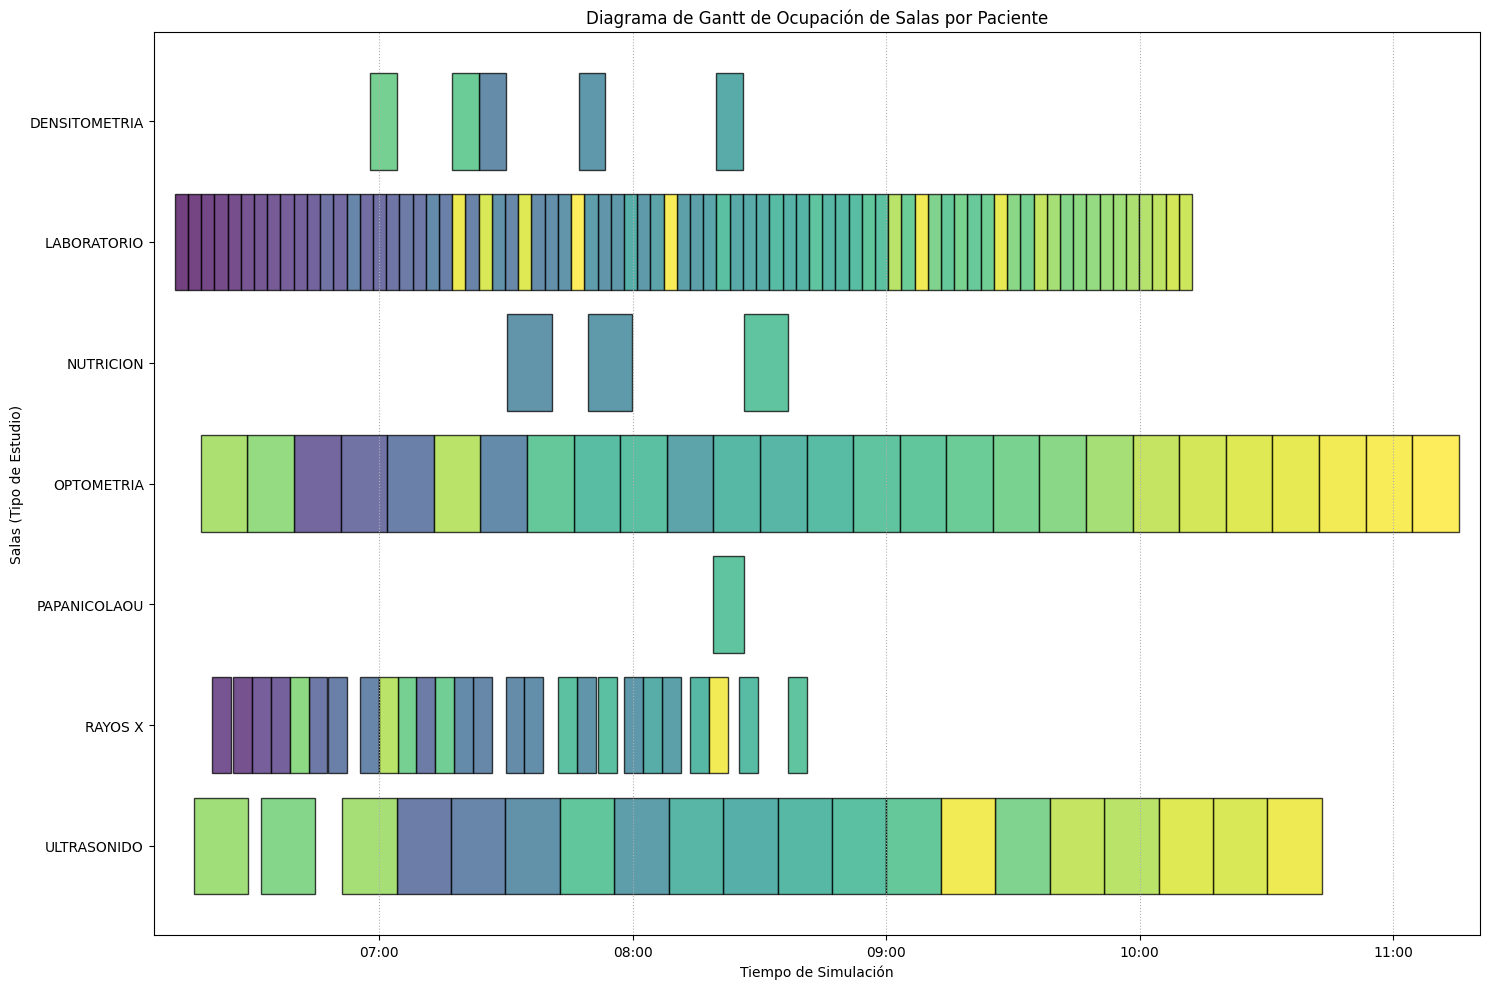

In [401]:
graph_algorithm(results_exhaustive_simple)

C:\Users\migue\AppData\Local\Temp\ipykernel_7868\3815169624.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(patient_ids)) # 'viridis' es un mapa de colores, puedes elegir otro


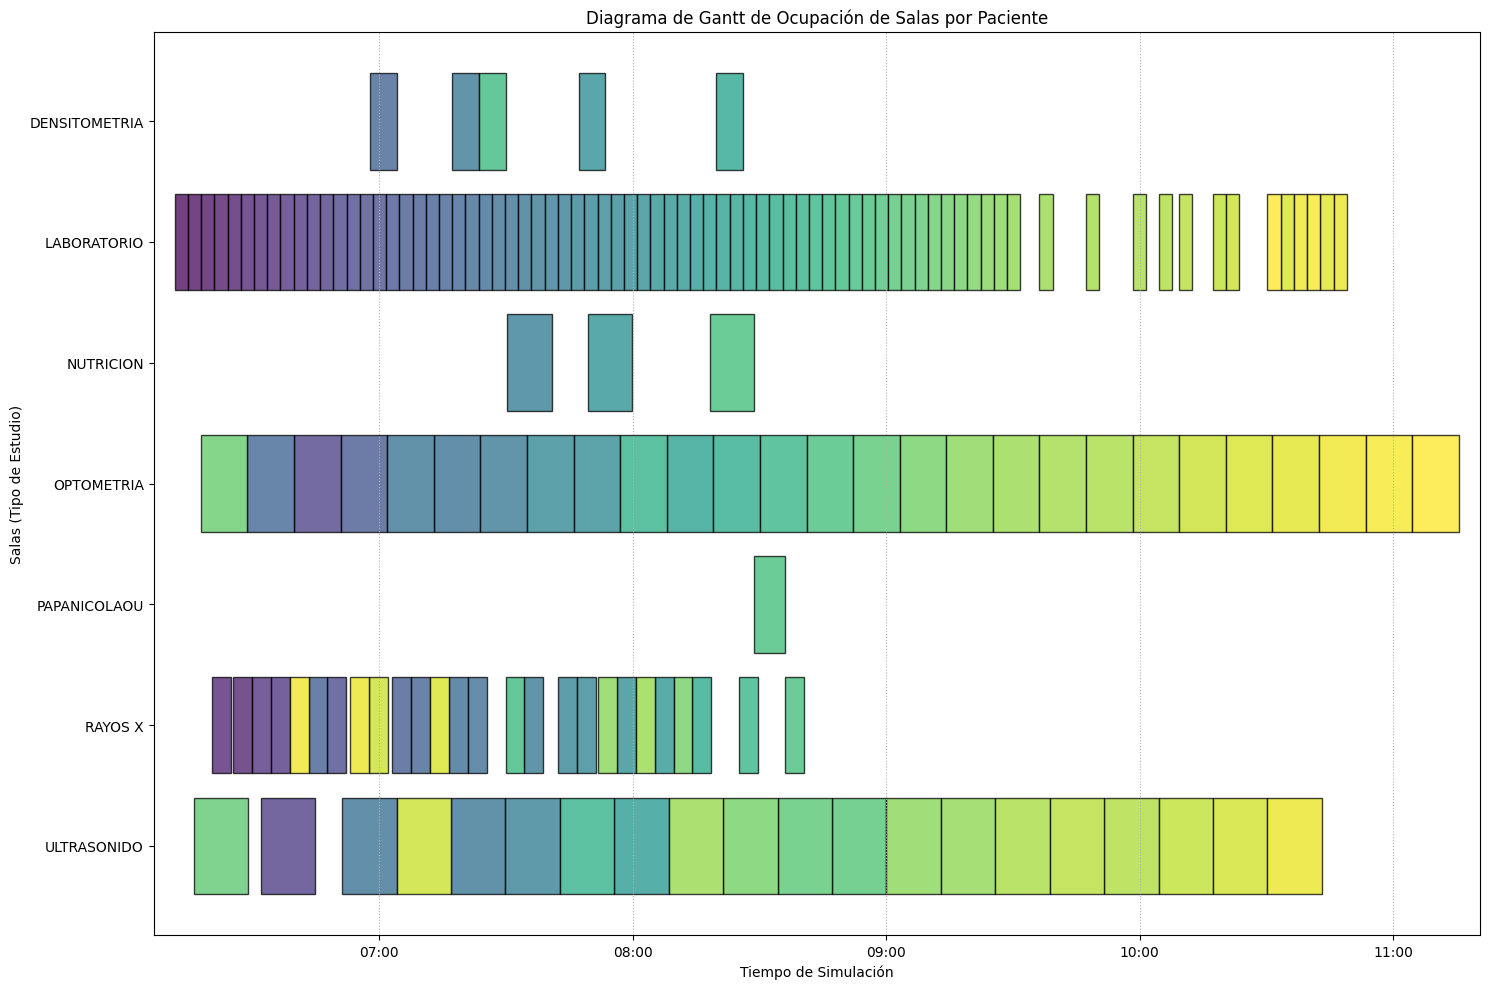

In [400]:
graph_algorithm(results_greedy_line_length)

# Simulacion masiva

In [481]:
    max_studies_per_patient = len(df_test[df_test["Sucursal"] == 'COYOACAN']["EstudioModalidad"].unique())
    MAX_STUDIES_PER_PATIENT = min(random.randint(6,8), max_studies_per_patient)
    
    num_studies = df_test[df_test["Sucursal"] == SIMULATED_SUCURSAL]["TAPFechaAtencion"].value_counts().mean()
    num_patients = int(num_studies/(MAX_STUDIES_PER_PATIENT/2))
    NUM_SIMULATED_PATIENTS =  num_patients + random.randint(- int(num_patients*.1), int(num_patients*.1))
    print(sucursal, NUM_SIMULATED_PATIENTS, MAX_STUDIES_PER_PATIENT)

CULIACAN NAKAYAMA 293 8


In [452]:
results_massive = pd.DataFrame(columns=['Sucursal','Algorithm', 'patients', 'completion_rate', 'avg_time_in_clinic', 'avg_wait_time_clinic', 'studies_completed'])
sucursales = list(df_test['Sucursal'].unique())
sucursales

['CULIACAN',
 'CULIACAN UNIVERSITARIOS',
 'CULIACAN CAÑADAS',
 'COYOACAN',
 'CULIACAN COLEGIO MILITAR',
 'CULIACAN LAS TORRES',
 'CULIACAN LA CONQUISTA',
 'CULIACAN NAKAYAMA']

In [387]:
for sucursal in sucursales:
    
    SIMULATED_SUCURSAL = sucursal
    SIMULATION_START_HOUR = 6
    SIMULATION_END_HOUR = 19
    DEFAULT_PROCESSING_TIME = 5
    DEFAULT_TEP_TIME = 15
    DEFAULT_TAP_TIME = 10
    
    max_studies_per_patient = len(df_test[df_test["Sucursal"] == SIMULATED_SUCURSAL]["EstudioModalidad"].unique())
    MAX_STUDIES_PER_PATIENT = min(random.randint(4, 8), max_studies_per_patient)
    
    num_studies = df_test[df_test["Sucursal"] == SIMULATED_SUCURSAL]["TAPFechaAtencion"].value_counts().mean()
    num_patients = int(num_studies/(MAX_STUDIES_PER_PATIENT/2))
    NUM_SIMULATED_PATIENTS =  num_patients + random.randint(- int(num_patients*.1), int(num_patients*.1))
    print(sucursal, NUM_SIMULATED_PATIENTS, MAX_STUDIES_PER_PATIENT)

    simulation_patients = generate_simulation_data(
        df_test, SIMULATED_SUCURSAL, NUM_SIMULATED_PATIENTS,
        SIMULATION_START_HOUR, SIMULATION_END_HOUR, MAX_STUDIES_PER_PATIENT, counts_by_time_slot
    )
    all_studies_in_sucursal = filter_studies_by_sucursal(df_test, SIMULATED_SUCURSAL)
    room_capabilities = infer_room_capabilities_from_studies(df_test, SIMULATED_SUCURSAL)
    kwargs = {'patients_list_orig':simulation_patients,'all_studies_in_sucursal':all_studies_in_sucursal, 'room_capabilities':room_capabilities}
    
    results_greedy_line_length =  run_multi_room_simulation_flexible(greedy_line_length, "Greedy Linea (Siguiente Paso)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_greedy_line_length, "Greedy Linea (Siguiente Paso)")
    results_massive = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'greedy_linea', patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results_massive.columns), results_massive], ignore_index=True)

    results_greedy_simple_step =  run_multi_room_simulation_flexible(greedy_simple, "Greedy Simple (Siguiente Paso)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_greedy_simple_step, "Greedy Simple (Siguiente Paso)")
    results_massive = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'greedy', patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results_massive.columns), results_massive], ignore_index=True)
    
    results_greedy_expected = run_multi_room_simulation_flexible(greedy_expected_value, "Greedy Expected Value (Siguiente Paso)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_greedy_expected, "Greedy Expected Value (Ruta Completa)")
    results_massive = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'greedy_E(x)', patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results_massive.columns), results_massive], ignore_index=True)
    
    results_random_full = run_multi_room_simulation_flexible(random_full_path_selection, "Aleatorio (Ruta Completa)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_random_full, "Aleatorio (Siguiente Paso)")
    results_massive = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'random', patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results_massive.columns), results_massive], ignore_index=True)
    
    results_exhaustive_simple = run_multi_room_simulation_flexible(exhaustive_search_simple, "Exhaustive Search Simple (Siguiente Paso)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_exhaustive_simple, "Exhaustive Search Simple (Siguiente Paso)")
    results_massive = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'exhaustive',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results_massive.columns), results_massive], ignore_index=True)
    
    results_exhaustive_expected = run_multi_room_simulation_flexible(exhaustive_search_expected_value, "Exhaustive Search Expected Value (Siguiente Paso)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_exhaustive_expected, "Exhaustive Search Expected Value (Ruta Completa)")
    results_massive = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'exhaustive_E(x)',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results_massive.columns), results_massive], ignore_index=True)
    
    results_exhaustive_simple = run_multi_room_simulation_flexible(exhaustive_search_simple_full, "Exhaustive Search Simple (Ruta Completa)",kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_exhaustive_simple, "Exhaustive Search Simple (Ruta Completa)")
    results_massive = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'exhaustive_full',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results_massive.columns), results_massive], ignore_index=True)
    
    results_exhaustive_expected = run_multi_room_simulation_flexible(exhaustive_search_expected_value_full, "Exhaustive Search Expected Value (Ruta Completa)", kwargs)
    patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_exhaustive_expected, "Exhaustive Search Expected Value (Ruta Completa)")
    results_massive = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'exhaustive_E(x)_full',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results_massive.columns), results_massive], ignore_index=True)   

CULIACAN 137 7

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Linea (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Expected Value (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Aleatorio (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Expected Value (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Expected Value (Ruta Completa) ---
CULIACAN UNIVERSITARIOS 66 7

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Linea (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Expected Val

In [388]:
refined_results = results_massive.groupby(['Algorithm'])['avg_time_in_clinic'].mean()

In [389]:
refined_results

Algorithm
exhaustive              178.256425
exhaustive_E(x)         179.060814
exhaustive_E(x)_full    124.701420
exhaustive_full         179.587407
greedy                  183.153849
greedy_E(x)             178.010866
greedy_linea            213.077038
random                  187.131587
Name: avg_time_in_clinic, dtype: float64

# JSON test

In [126]:
simulation_patients[0]

{'Patient_ID': 'GenP1',
 'Arrival_Time': datetime.datetime(2025, 6, 4, 7, 5, 36, 517122),
 'Requested_Studies': ['LABORATORIO'],
 'Remaining_Studies': ['LABORATORIO'],
 'Current_Availability_Time': datetime.datetime(2025, 6, 4, 7, 5, 36, 517122),
 'Path_Details': [],
 'Total_Wait_Time_Clinic': datetime.timedelta(0),
 'Overall_Completion_Time': None,
 'Needs_New_Step_Decision': True}

In [128]:
def transform_json_patient_data(raw_patients_list):
    transformed_patients = []
    today_date = date.today()

    for raw_patient in raw_patients_list:
        try:
            arrival_time_obj = datetime.strptime(raw_patient['Arrival_Time'], '%H:%M:%S').time()
        except ValueError:
            print(f"Advertencia: Formato de hora inválido para Patient_ID {raw_patient.get('Patient_ID', 'Desconocido')}: {raw_patient['Arrival_Time']}. Usando medianoche como default.")
            arrival_time_obj = datetime.min.time()
        arrival_datetime = datetime.combine(today_date, arrival_time_obj)
        
        requested_studies_copy = list(raw_patient.get('Requested_Studies', []))

        transformed_patient = {
            'Patient_ID': raw_patient.get('Patient_ID', 'N/A'),
            'Arrival_Time': arrival_datetime,
            'Requested_Studies': requested_studies_copy, # Mantener la lista original
            'Remaining_Studies': list(requested_studies_copy), # Una copia para modificar
            'Current_Availability_Time': arrival_datetime, # Inicialmente igual a la llegada
            'Path_Details': [],
            'Total_Wait_Time_Clinic': timedelta(0),
            'Overall_Completion_Time': None,
            'Needs_New_Step_Decision': True
        }
        transformed_patients.append(transformed_patient)
        
    return transformed_patients


In [129]:
import json

with open('simulation_data.json', 'r') as f:
    json_data = json.load(f)

json_data[0]['pacientes'][0]

{'Patient_ID': 'GenP1',
 'Arrival_Time': '07:05:50',
 'Requested_Studies': ['ULTRASONIDO', 'LABORATORIO', 'DENSITOMETRIA']}

In [131]:
transform_json_patient_data([json_data[0]['pacientes'][0]])

[{'Patient_ID': 'GenP1',
  'Arrival_Time': datetime.datetime(2025, 6, 4, 7, 5, 50),
  'Requested_Studies': ['ULTRASONIDO', 'LABORATORIO', 'DENSITOMETRIA'],
  'Remaining_Studies': ['ULTRASONIDO', 'LABORATORIO', 'DENSITOMETRIA'],
  'Current_Availability_Time': datetime.datetime(2025, 6, 4, 7, 5, 50),
  'Path_Details': [],
  'Total_Wait_Time_Clinic': datetime.timedelta(0),
  'Overall_Completion_Time': None,
  'Needs_New_Step_Decision': True}]

In [132]:
results_json = pd.DataFrame(columns=['Sucursal','Algorithm', 'completion_rate', 'avg_time_in_clinic', 'avg_wait_time_clinic'])

for item in json_data:
    # Generar datos de pacientes
    SIMULATED_SUCURSAL = item['Sucursal']
    DEFAULT_PROCESSING_TIME = 5
    DEFAULT_TEP_TIME = 15
    DEFAULT_TAP_TIME = 10

    simulation_patients = transform_json_patient_data(item['pacientes'])
    all_studies_in_sucursal = filter_studies_by_sucursal(df_test, SIMULATED_SUCURSAL)

    if not all_studies_in_sucursal:
        print(f"No se encontraron estudios para la sucursal {SIMULATED_SUCURSAL}. Deteniendo la simulación.")
    else:
        results_greedy_simple_step =  run_multi_room_simulation_flexible(
            simulation_patients, 
            greedy_simple, 
            "Greedy Simple (Siguiente Paso)",
            all_studies_in_sucursal,
            room_capabilities
        )
        patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_greedy_simple_step, "Greedy Simple (Siguiente Paso)")
        results_json = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'greedy',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results_json], ignore_index=True)

        results_greedy_expected_full = run_multi_room_simulation_flexible(
            simulation_patients, 
            greedy_expected_value, 
            "Greedy Expected Value (Siguiente Paso)",
            all_studies_in_sucursal,
            room_capabilities
        )
        patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_greedy_expected_full, "Greedy Expected Value (Ruta Completa)")
        results_json = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'greedy_E(x)',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results_json], ignore_index=True)

        results_random_full = run_multi_room_simulation_flexible(
            simulation_patients,
            random_full_path_selection,
            "Aleatorio (Ruta Completa)",
            all_studies_in_sucursal,
            room_capabilities,
        )
        patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_random_full, "Aleatorio (Siguiente Paso)")
        results_json = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'random',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results_json], ignore_index=True)

        results_exhaustive_simple = run_multi_room_simulation_flexible(
            simulation_patients,
            exhaustive_search_simple, 
            "Exhaustive Search Simple (Siguiente Paso)",
            all_studies_in_sucursal,
            room_capabilities
        )
        patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_exhaustive_simple, "Exhaustive Search Simple (Siguiente Paso)")
        results_json = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'exhaustive',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results_json], ignore_index=True)

        results_exhaustive_expected = run_multi_room_simulation_flexible(
            simulation_patients,
            exhaustive_search_expected_value, 
            "Exhaustive Search Expected Value (Siguiente Paso)",
            all_studies_in_sucursal,
            room_capabilities
        )
        patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_exhaustive_expected, "Exhaustive Search Expected Value (Ruta Completa)")
        results_json = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'exhaustive_E(x)',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results_json], ignore_index=True)

        results_exhaustive_simple = run_multi_room_simulation_flexible(
            simulation_patients,
            exhaustive_search_simple_full, 
            "Exhaustive Search Simple (Ruta Completa)",
            all_studies_in_sucursal,
            room_capabilities,
        )
        patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_exhaustive_simple, "Exhaustive Search Simple (Ruta Completa)")
        results_json = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'exhaustive_full',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results_json], ignore_index=True)

        results_exhaustive_expected = run_multi_room_simulation_flexible(
            simulation_patients,
            exhaustive_search_expected_value_full, 
            "Exhaustive Search Expected Value (Ruta Completa)",
            all_studies_in_sucursal,
            room_capabilities,
        )
        patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed = analyze_simulation_results(results_exhaustive_expected, "Exhaustive Search Expected Value (Ruta Completa)")
        results_json = pd.concat([pd.DataFrame([[SIMULATED_SUCURSAL,'exhaustive_E(x)_full',patients, completion_rate, avg_time_in_clinic, avg_wait_time_clinic, studies_completed]], columns=results.columns), results_json], ignore_index=True)   



--- Ejecutando Simulación Multi-Sala Flexible: Greedy Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Expected Value (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Aleatorio (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Expected Value (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Expected Value (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Expected Value (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Aleatorio (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Siguiente Paso) ---

--- Ejecuta


--- Ejecutando Simulación Multi-Sala Flexible: Aleatorio (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Expected Value (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Expected Value (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Expected Value (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Aleatorio (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Expected Value (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Ruta Compl


--- Ejecutando Simulación Multi-Sala Flexible: Greedy Expected Value (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Aleatorio (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Expected Value (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Expected Value (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Greedy Expected Value (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Aleatorio (Ruta Completa) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Simple (Siguiente Paso) ---

--- Ejecutando Simulación Multi-Sala Flexible: Exhaustive Search Expected Value (Siguiente Pas

In [262]:
refined_results_json = results_json.groupby(['Algorithm'])['avg_time_in_clinic'].mean()
refined_results_json

Algorithm
exhaustive              158.870839
exhaustive_E(x)         159.517795
exhaustive_E(x)_full    159.203520
exhaustive_full         158.906946
greedy                  157.314504
greedy_E(x)             160.633070
random                  166.204577
Name: avg_time_in_clinic, dtype: float64